# **Práctica 3 - Planificación de Caminos**

**Autores:**

1.  Jorge Elías García. [jorge.elias@alumnos.upm.es](mailto:jorge.elias@alumnos.upm.es)
2.  Jordi Florit Ensenyat [j.florit@alumnos.upm.es](mailto:j.florit@alumnos.upm.es)
3. Josep Gabriel Fornes Reynes [josep.fornes@alumnos.upm.es](mailto:josep.fornes@alumnos.upm.es)


# **Introducción**


En esta práctica de se ha desarrollado un sistema de **planificación de caminos (path planning)** cuyo objetivo es calcular un camino válido entre un punto inicial y un punto final dentro de un entorno con obstáculos. El problema se plantea en términos de planificación (no navegación), por lo que **no se utiliza un simulador de robot**: el foco está en el algoritmo que genera la ruta a partir de una representación del espacio.

El sistema implementado recibe como **entrada**: En primer lugar, un **mapa del entorno en formato imagen .PNG**  y, en segundo lugar, dos coordenadas en píxeles correspondientes al **punto de inicio** (*start*) y al **punto objetivo** (*goal*). A partir de esa entrada, el mapa se transforma en una **rejilla de ocupación** (*occupancy grid*) binaria donde cada celda indica si es **travesable** o **obstáculo**. Como **salida**, el sistema genera una **visualización** del mapa con el camino resultante superpuesto.

Se han implementado y evaluado **dos enfoques de planificación complementarios**:

- **Theta\***: algoritmo de búsqueda sobre rejilla derivado de A\* que incorpora **línea de visión (line-of-sight)** para producir rutas más directas y naturales que las obtenidas con conectividad estricta de la rejilla.
- **RRT (Rapidly-exploring Random Tree)**: algoritmo de planificación **basado en muestreo (sampling-based)**, especialmente relevante en robótica, que explora el espacio construyendo un árbol de expansión rápida y utiliza comprobaciones de colisión sobre el mapa.

Para facilitar el uso y la experimentación, el sistema incluye una **previsualización del mapa** con ejes y marcas de coordenadas para seleccionar *start* y *goal* con precisión, y se ha probado sobre **múltiples “mundos”** (mapas) con distintos pares de puntos de inicio/fin. Finalmente, se realiza un **análisis crítico** comparando ambos planificadores en términos de capacidad de encontrar solución, calidad del camino (p. ej., geometría/longitud) y consideraciones prácticas (resolución del mapa, pasillos estrechos, etc.).


Descarga de las librerías necesarias.

In [ ]:
!pip install numpy pillow matplotlib

# **Funciones auxiliares para visualizar los mapas**



Desde el inicio de la práctica se definen una serie de **funciones auxiliares** destinadas a la **carga y visualización de los mapas**, que se reutilizarán durante la ejecución y evaluación de los algoritmos de planificación para diferentes escenas.

- `load_occupancy_from_image(...)`: Tansforma un mapa en formato imagen a una rejilla de ocupación (espacio libre vs. obstáculos) que pueda ser utilizada directamente por los planificadores.
- `preview_map(...)`: Permite inspeccionar visualmente el mapa con coordenadas para elegir con precisión los puntos de inicio y objetivo antes de ejecutar los algoritmos.
- `plot_and_save(...)`: Genera la salida visual requerida por la práctica, mostrando el mapa junto con la trayectoria resultante y guardando la imagen para su comparación y análisis posterior.


In [ ]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import math
import heapq
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional


# Preprocesamos el mapa de entrada a una rejilla de ocupación.
# Consideramos blanco (libre) y negro (pared), utilizando un threshold=128.
def load_occupancy_from_image(
    image_path: str,
    threshold: int = 128,
    invert: bool = False,
) -> np.ndarray:
    img = Image.open(image_path).convert("L")  # escala de grises
    arr = np.array(img)

    if invert:
        free = arr < threshold
    else:
        free = arr > threshold

    grid = np.where(free, 0, 1).astype(np.uint8)
    return grid

# Previsualizamos el mapa en una rejilla con coordenadas para seleccionar de manera más precisa los puntos de inicio y final.
def preview_map(grid, title="Mapa (sin camino)", tick_step=25, show_grid=True):
    h, w = grid.shape

    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray_r")  # paredes negras, libre blanco
    plt.gca().invert_yaxis()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

    plt.xticks(np.arange(0, w, tick_step))
    plt.yticks(np.arange(0, h, tick_step))

    # Rejilla opcional para mayor precisión visual
    if show_grid:
        plt.grid(True, linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.show()

# Generamos la salida con el mapa y recorrido
def plot_and_save(
    grid: np.ndarray,
    start: Tuple[int, int],
    goal: Tuple[int, int],
    path: Optional[List[Tuple[int, int]]],
    out_path: str,
    out_dir: str,
    title: str,
):
    # Creamos la carpeta si no existe
    os.makedirs(out_dir, exist_ok=True)

    save_path = os.path.join(out_dir, out_path)

    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray_r")
    plt.scatter([start[0]], [start[1]], marker="o", s=60, label="start")
    plt.scatter([goal[0]], [goal[1]], marker="x", s=60, label="goal")

    if path:
        xs = [p[0] for p in path]
        ys = [p[1] for p in path]
        plt.plot(xs, ys, linewidth=2, label="path")

    plt.gca().invert_yaxis()
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()

    plt.savefig(save_path, dpi=200)
    plt.close()

# **Theta\*: Planificación en Rejilla con Atajos por Línea de Visión**



Theta\* es un algoritmo de planificación de caminos diseñado para entornos representados como una **rejilla** (*grid*), donde cada celda se clasifica como espacio libre u obstáculo. Su objetivo es encontrar una ruta desde un punto de inicio hasta un objetivo **minimizando el coste total**, pero evitando en la medida de lo posible los caminos artificialmente “en escalera” que aparecen cuando solo se permiten movimientos entre celdas vecinas. Para ello, Theta\* realiza una búsqueda **guiada por heurística**: va explorando progresivamente las zonas del mapa que parecen más prometedoras, priorizando aquellos puntos que combinan un coste acumulado bajo desde el inicio con una estimación (heurística) de lo que falta para llegar al objetivo. Conceptualmente, esta priorización puede entenderse como ordenar los candidatos por una función del tipo
\[
f(n)=g(n)+h(n),
\]
donde \(g(n)\) es el coste ya recorrido hasta el punto \(n\) y \(h(n)\) estima el coste restante hasta la meta.

La característica diferencial de Theta\* respecto al famoso algoritmo A* es que, aunque explora el espacio sobre una rejilla, **no “construye” necesariamente el camino final enlazando siempre celdas consecutivas**. En lugar de eso, cada vez que incorpora un nuevo punto del entorno a su ruta, comprueba si puede conectarlo directamente con un punto anterior del camino mediante **línea de visión**, es decir, si existe un segmento recto entre ambos que no atraviese obstáculos. Cuando esa conexión directa es posible, Theta\* la prefiere porque reduce giros innecesarios y produce trayectorias más parecidas a las que seguiría un robot en un entorno continuo.

Como resultado, Theta\* suele generar caminos **más cortos y "rectos"**, manteniendo la eficiencia de una búsqueda informada, a cambio de realizar comprobaciones adicionales de visibilidad y de depender (como cualquier método en rejilla) de la **resolución** del mapa discretizado.


In [ ]:
# ======================================
# Utilidades: vecinos + líneas de visión
# ======================================

# Comprobams si unas coordenadas (x, y) están dentro de los límites del mapa.
def in_bounds(grid: np.ndarray, x: int, y: int) -> bool:
    h, w = grid.shape
    return 0 <= x < w and 0 <= y < h

# Determinamos si la celda es transitable
def is_free(grid: np.ndarray, x: int, y: int) -> bool:
    return in_bounds(grid, x, y) and grid[y, x] == 0

# Generamos los vecinos transitables de una celda usando conectividad 8 (incluye diagonales),
# devolviendo también el coste de cada movimiento (1 en ortogonales y √2 en diagonales).
def neighbors8(grid: np.ndarray, x: int, y: int):
    moves = [
        (-1,  0, 1.0), (1,  0, 1.0), (0, -1, 1.0), (0,  1, 1.0),
        (-1, -1, math.sqrt(2)), (1, -1, math.sqrt(2)),
        (-1,  1, math.sqrt(2)), (1,  1, math.sqrt(2)),
    ]
    for dx, dy, c in moves:
        nx, ny = x + dx, y + dy
        if is_free(grid, nx, ny):
            yield (nx, ny, c)

# En nuestra implementación la heurística es la distancia euclídea desde el nodo n hasta el objetivo goal.
def euclidean(a: Tuple[int, int], b: Tuple[int, int]) -> float:
    return math.hypot(a[0] - b[0], a[1] - b[1])

# Algoritmo de Bresenham: discretizamos el segmento entre (x0,y0) y (x1,y1) en una secuencia de píxeles,
# permitiendo comprobar colisiones/visibilidad sobre una rejilla.
def bresenham_line(x0: int, y0: int, x1: int, y1: int):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    x, y = x0, y0
    while True:
        yield x, y
        if x == x1 and y == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

# Función para identificar líneas de visión. Devolvemos True si el segmento a -> b no atraviesa obstáculos.
# Nos apoyamos en Bresenham para recorrer los píxeles del segmento y verificar que todos son transitables.
def line_of_sight(grid: np.ndarray, a: Tuple[int, int], b: Tuple[int, int]) -> bool:
    x0, y0 = a
    x1, y1 = b
    for x, y in bresenham_line(x0, y0, x1, y1):
        if not is_free(grid, x, y):
            return False
    return True


# =========================
# Algoritmo Theta*
# =========================

# Estructura auxiliar para la cola de prioridad (open set).
# Guardamos f(n)=g(n)+h(n) y el nodo asociado, para extraer siempre el más prometedor.
@dataclass(order=True)
class PQItem:
    f: float
    node: Tuple[int, int]


# Reconstruimos el camino final recorriendo punteros "parent" desde el objetivo hasta el inicio.
# El resultado es una lista ordenada de puntos (x, y) desde start hasta goal.
def reconstruct_path(parent: Dict[Tuple[int, int], Tuple[int, int]],
                     start: Tuple[int, int],
                     goal: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    cur = goal
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path


# Implementación de Theta* sobre un grid con conectividad 8 (arriba, abajo, laterales y diagonales).
# A diferencia de A*, intentamos "atajar" conectando un vecino con el padre del nodo actual si hay línea de visión,
# generando caminos más directos (menos efecto escalera) sin perder el enfoque de búsqueda guiada por heurística.
def theta_star(
    grid: np.ndarray,
    start: Tuple[int, int],
    goal: Tuple[int, int],
) -> Optional[List[Tuple[int, int]]]:

    # Validación: start y goal deben estar dentro del mapa y en celdas transitables.
    if not is_free(grid, *start):
        raise ValueError(f"Start {start} está en obstáculo o fuera del mapa.")
    if not is_free(grid, *goal):
        raise ValueError(f"Goal {goal} está en obstáculo o fuera del mapa.")

    # g(n): mejor coste conocido desde start hasta n.
    # parent(n): puntero al nodo anterior del camino (para reconstrucción). Inicialmente start apunta a sí mismo.
    g: Dict[Tuple[int, int], float] = {start: 0.0}
    parent: Dict[Tuple[int, int], Tuple[int, int]] = {start: start}

    # Open set: cola de prioridad ordenada por f(n)=g(n)+h(n). Empezamos con el nodo inicial.
    open_heap: List[PQItem] = []
    heapq.heappush(open_heap, PQItem(euclidean(start, goal), start))

    # Closed set: nodos ya procesados definitivamente.
    closed = set()

    while open_heap:
        # Extraemos el nodo con menor f: el más prometedor según coste acumulado + heurística.
        current = heapq.heappop(open_heap).node

        if current in closed:
            continue

        # Si alcanzamos goal, reconstruimos el camino usando los punteros parent.
        if current == goal:
            return reconstruct_path(parent, start, goal)

        closed.add(current)
        cx, cy = current

        # Exploramos vecinos transitables (8-conectividad).
        for nx, ny, step_cost in neighbors8(grid, cx, cy):
            n = (nx, ny)
            if n in closed:
                continue

            # Intentamos conectar el vecino n con el padre de current si hay línea de visión.
            # Si es posible, se reduce el zigzag y se obtiene un tramo más recto.
            p = parent[current]

            if line_of_sight(grid, p, n):
                # Atajo: coste desde el ancestro p hasta n (segmento recto).
                tentative_g = g[p] + euclidean(p, n)
                tentative_parent = p
            else:
                # Coste normal pasando por current
                tentative_g = g[current] + step_cost
                tentative_parent = current

            # Relajación: si encontramos una mejor forma de llegar a n, actualizamos coste y padre.
            if tentative_g < g.get(n, float("inf")):
                g[n] = tentative_g
                parent[n] = tentative_parent

                # Priorizamos con f(n)=g(n)+h(n) usando heurística euclídea hasta goal.
                f = tentative_g + euclidean(n, goal)
                heapq.heappush(open_heap, PQItem(f, n))

    # Si se agota la cola, no hay camino posible (o el mapa está completamente bloqueado).
    return None



## **Ejemplo Labirinto_003**

In [ ]:
IMG_PATH =  "/content/Labirinto_003.png"

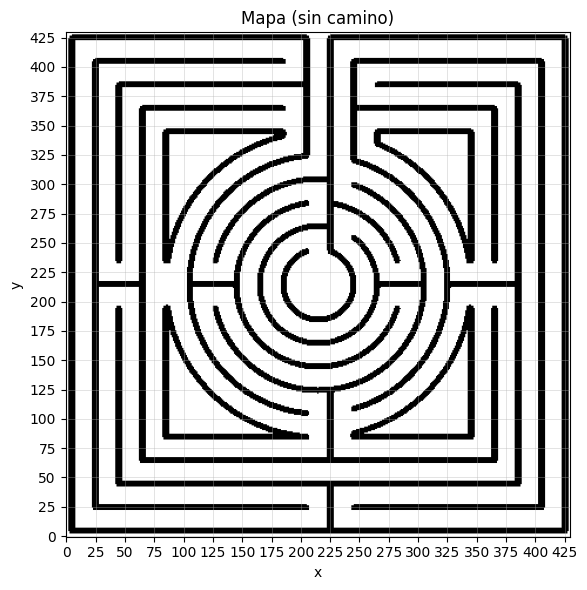

In [ ]:
grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
nombre_archivo = os.path.splitext(os.path.basename(IMG_PATH))[0]
preview_map(grid)

In [ ]:
# Coordenadas (x, y) en píxeles:
start = [(210, 10),(300, 10),(210, 420)]
goal = [(225, 225),(225, 225),(225, 225)]

OUTPUT_DIR = f"/content/resultados_{nombre_archivo}"


In [ ]:
print(f"Procesando: {nombre_archivo}")
print(f"Los resultados se guardarán en: {OUTPUT_DIR}")

for i in range(len(start)):
    path = theta_star(grid, start[i], goal[i])
    plot_and_save(
        grid,
        start[i],
        goal[i],
        path,
        out_path=f"ruta_{i}.png",
        out_dir=OUTPUT_DIR,
        title=f"Path {i} en {nombre_archivo}"
    )

Procesando: Labirinto_003
Los resultados se guardarán en: /content/resultados_Labirinto_003


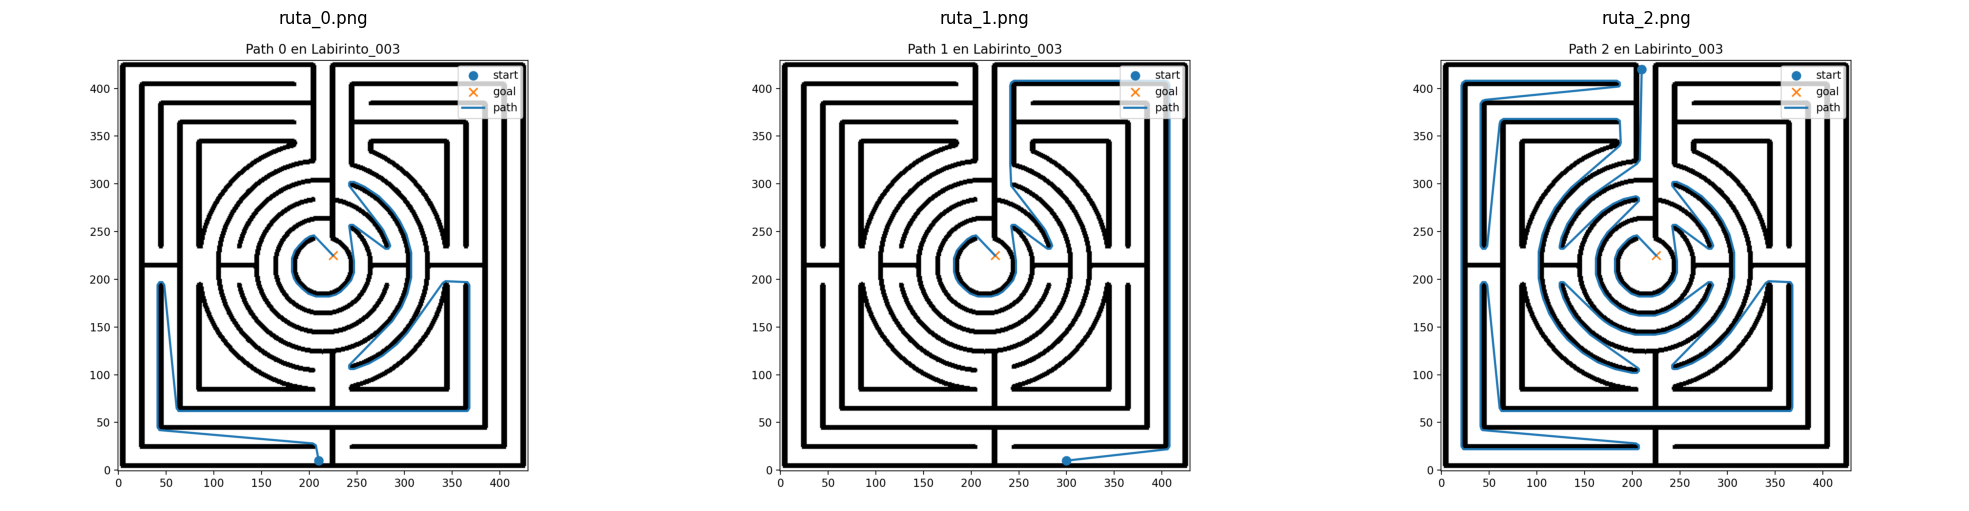

In [ ]:
# Obtener rutas y cargar datos
ruta_resultados = Path(OUTPUT_DIR)
lista_imagenes = sorted(list(ruta_resultados.glob("*.png")))

if lista_imagenes:
    fig, axes = plt.subplots(1, len(lista_imagenes), figsize=(20, 5))
    # Si solo hay 1 imagen, axes no es una lista, hay que hacerlo iterable
    if len(lista_imagenes) == 1: axes = [axes]

    for i, ax in enumerate(axes):
        img = plt.imread(str(lista_imagenes[i]))
        ax.imshow(img)
        ax.set_title(lista_imagenes[i].name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron imágenes guardadas.")



## **Planta de El Prado**

In [ ]:
IMG_PATH =  "/content/Planta_de_El_Prado.png"

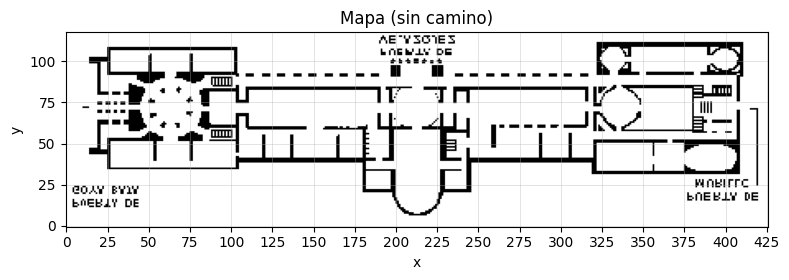

In [ ]:
grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
nombre_archivo = os.path.splitext(os.path.basename(IMG_PATH))[0]
preview_map(grid)

In [ ]:
start = [(60, 70),(60, 100),(90, 40)]
goal = [(400, 70),(400, 70),(400, 70)]

OUTPUT_DIR = f"/content/resultados_{nombre_archivo}"

In [ ]:
print(f"Procesando: {nombre_archivo}")
print(f"Los resultados se guardarán en: {OUTPUT_DIR}")

for i in range(len(start)):
    path = theta_star(grid, start[i], goal[i])
    plot_and_save(
        grid,
        start[i],
        goal[i],
        path,
        out_path=f"ruta_{i}.png",
        out_dir=OUTPUT_DIR,
        title=f"Path {i} en {nombre_archivo}"
    )

Procesando: Planta_de_El_Prado
Los resultados se guardarán en: /content/resultados_Planta_de_El_Prado


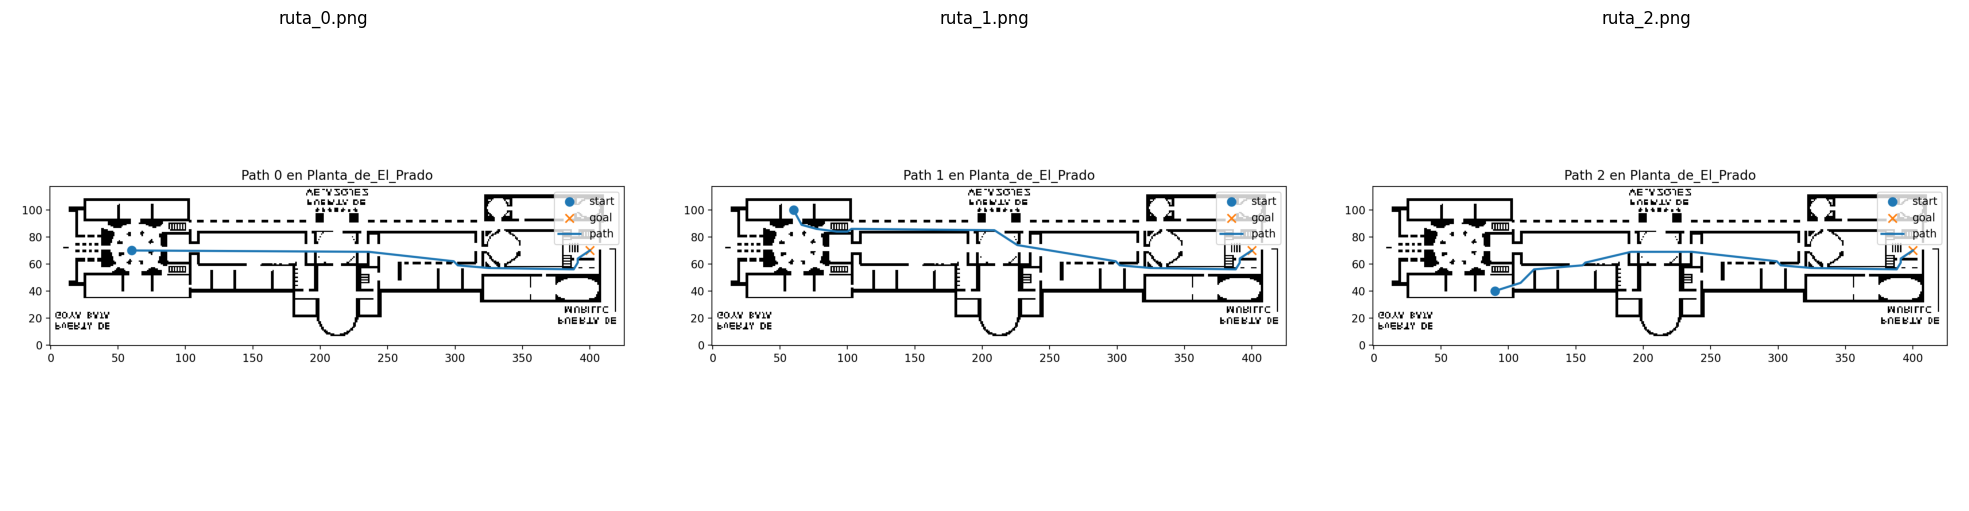

In [ ]:
# Obtener rutas y cargar datos
ruta_resultados = Path(OUTPUT_DIR)
lista_imagenes = sorted(list(ruta_resultados.glob("*.png")))

if lista_imagenes:
    fig, axes = plt.subplots(1, len(lista_imagenes), figsize=(20, 5))
    # Si solo hay 1 imagen, axes no es una lista, hay que hacerlo iterable
    if len(lista_imagenes) == 1: axes = [axes]

    for i, ax in enumerate(axes):
        img = plt.imread(str(lista_imagenes[i]))
        ax.imshow(img)
        ax.set_title(lista_imagenes[i].name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron imágenes guardadas.")

## **Ejemplo Maze01-01**

In [ ]:
IMG_PATH =  "/content/Maze01-01.png"

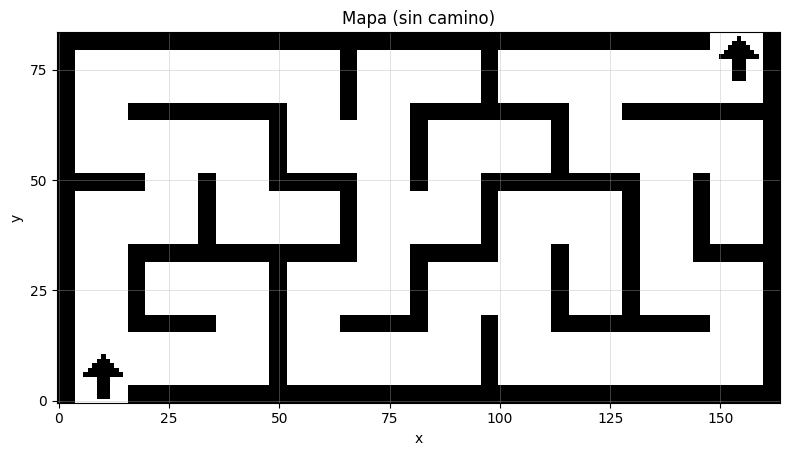

In [ ]:
grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
nombre_archivo = os.path.splitext(os.path.basename(IMG_PATH))[0]
preview_map(grid)

In [ ]:
# Coordenadas (x, y) en píxeles:
start = [(15, 1),(25, 25),(10, 75)]
goal = [(150, 80),(150, 80),(150, 80)]

OUTPUT_DIR = f"/content/resultados_{nombre_archivo}"

In [ ]:
print(f"Procesando: {nombre_archivo}")
print(f"Los resultados se guardarán en: {OUTPUT_DIR}")

for i in range(len(start)):
    path = theta_star(grid, start[i], goal[i])
    plot_and_save(
        grid,
        start[i],
        goal[i],
        path,
        out_path=f"ruta_{i}.png",
        out_dir=OUTPUT_DIR,
        title=f"Path {i} en {nombre_archivo}"
    )

Procesando: Maze01-01
Los resultados se guardarán en: /content/resultados_Maze01-01


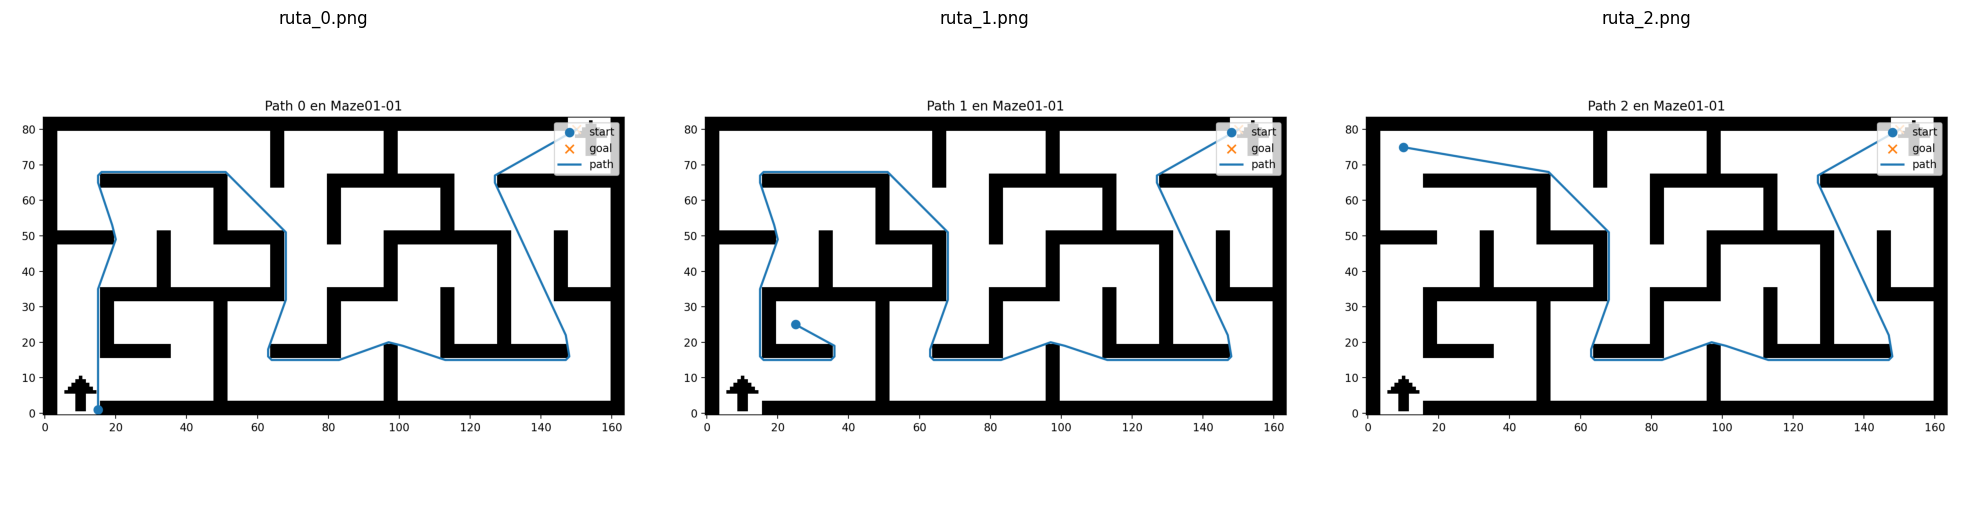

In [ ]:
# Obtener rutas y cargar datos
ruta_resultados = Path(OUTPUT_DIR)
lista_imagenes = sorted(list(ruta_resultados.glob("*.png")))

if lista_imagenes:
    fig, axes = plt.subplots(1, len(lista_imagenes), figsize=(20, 5))
    # Si solo hay 1 imagen, axes no es una lista, hay que hacerlo iterable
    if len(lista_imagenes) == 1: axes = [axes]

    for i, ax in enumerate(axes):
        img = plt.imread(str(lista_imagenes[i]))
        ax.imshow(img)
        ax.set_title(lista_imagenes[i].name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron imágenes guardadas.")

## **Mapa Nuestro Propio**

In [ ]:
IMG_PATH =  "/content/mapa_propio.png"

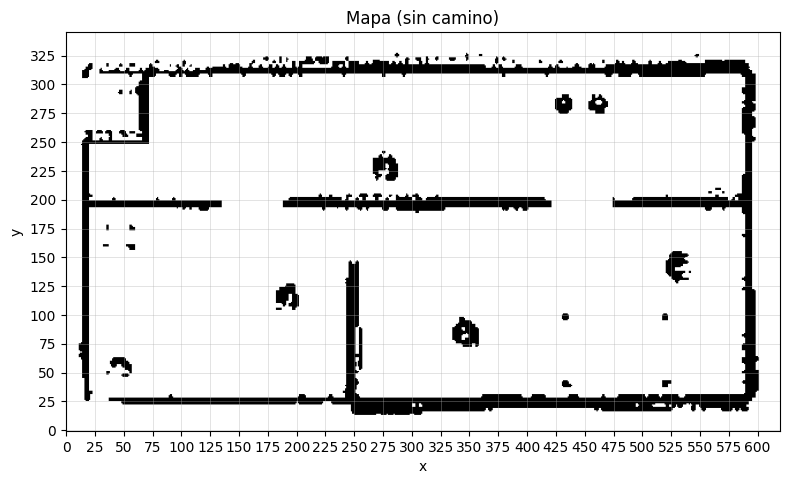

In [ ]:
grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
nombre_archivo = os.path.splitext(os.path.basename(IMG_PATH))[0]
preview_map(grid)

In [ ]:
# Coordenadas (x, y) en píxeles:
start = [(25, 25),(50, 175),(575, 50)]
goal = [(570, 300),(570, 300),(570, 300)]

OUTPUT_DIR = f"/content/resultados_{nombre_archivo}"

In [ ]:
print(f"Procesando: {nombre_archivo}")
print(f"Los resultados se guardarán en: {OUTPUT_DIR}")

for i in range(len(start)):
    path = theta_star(grid, start[i], goal[i])
    plot_and_save(
        grid,
        start[i],
        goal[i],
        path,
        out_path=f"ruta_{i}.png",
        out_dir=OUTPUT_DIR,
        title=f"Path {i} en {nombre_archivo}"
    )

Procesando: mapa_propio
Los resultados se guardarán en: /content/resultados_mapa_propio


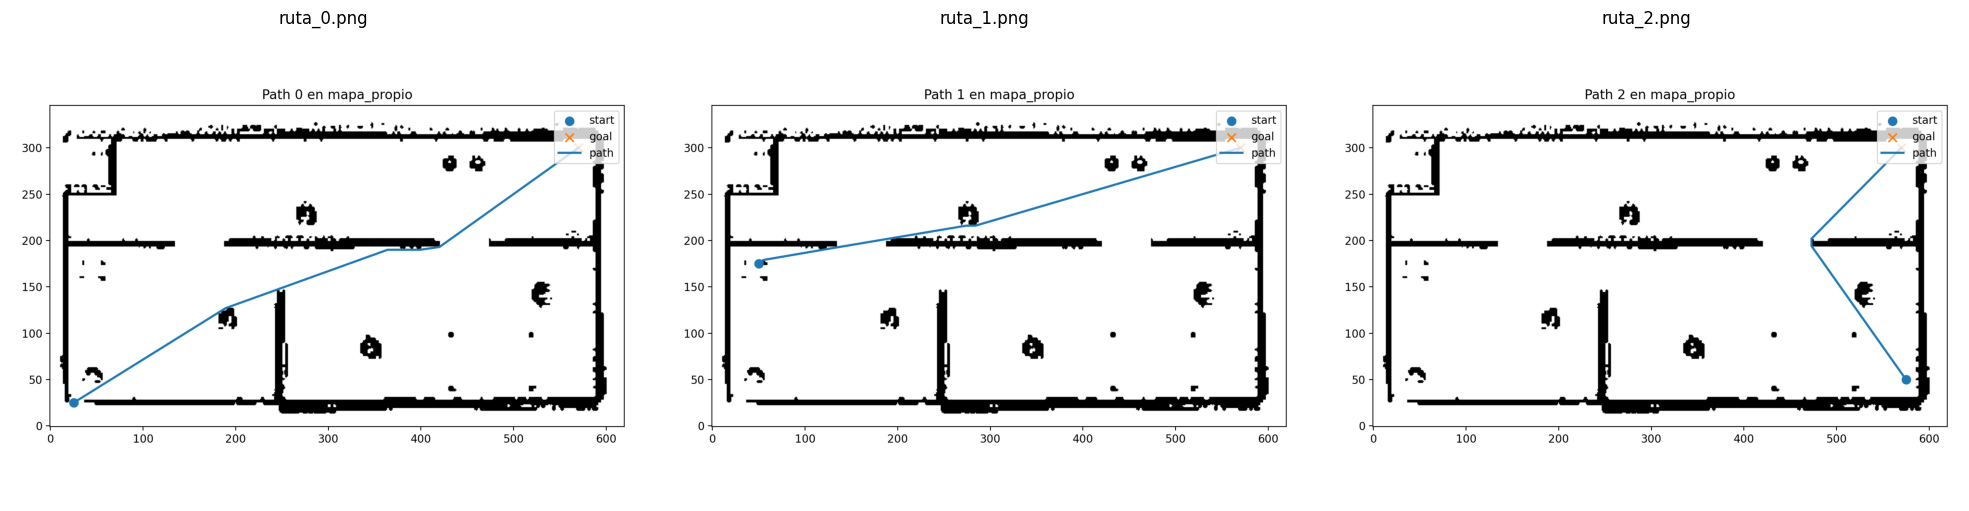

In [ ]:
# Obtener rutas y cargar datos
ruta_resultados = Path(OUTPUT_DIR)
lista_imagenes = sorted(list(ruta_resultados.glob("*.png")))

if lista_imagenes:
    fig, axes = plt.subplots(1, len(lista_imagenes), figsize=(20, 5))
    # Si solo hay 1 imagen, axes no es una lista, hay que hacerlo iterable
    if len(lista_imagenes) == 1: axes = [axes]

    for i, ax in enumerate(axes):
        img = plt.imread(str(lista_imagenes[i]))
        ax.imshow(img)
        ax.set_title(lista_imagenes[i].name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron imágenes guardadas.")

## **Conclusión Algoritmo Theta\***

Finalmente, concluimos que el algoritmo Theta\* codificado ha funcionado de manera sólida en todos los mapas evaluados, siendo capaz de encontrar **caminos válidos y de buena calidad** para los distintos pares de puntos de inicio y objetivo considerados. En todos los escenarios probados, el planificador **converge correctamente y produce trayectorias coherentes con la geometría del entorno**

En los resultados obtenidos se aprecia claramente el **impacto del uso de líneas de visión**, ya que los caminos generados son en su mayoría **muy directos y prácticamente rectilíneos**, evitando el efecto “en escalera” característico de los planificadores restringidos a movimientos entre celdas vecinas. Como consecuencia, las trayectorias se ajustan mejor a la estructura del mapa y se aproximan a rutas más naturales.

Además, en varios casos se observa que el camino tiende a discurrir **cerca de paredes u obstáculos**, lo cual es consistente con el objetivo de minimizar la distancia: al aprovechar segmentos rectos siempre que son viables, las rutas óptimas suelen “tensarse” dentro del espacio libre y apoyarse en los límites de los obstáculos para mantener el recorrido lo más corto posible sin colisionar. En conjunto, los resultados confirman que Theta\* es un **planificador eficaz y adecuado para entornos discretizados, ofreciendo un excelente equilibrio entre calidad geométrica de la ruta y eficiencia.**


# **Algoritmo RRT**

In [ ]:
import random
import math
from dataclasses import dataclass
from typing import List, Tuple, Optional

def is_free(grid, x, y):
    h, w = grid.shape
    return 0 <= x < w and 0 <= y < h and grid[y, x] == 0

def bresenham_line(x0, y0, x1, y1):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    x, y = x0, y0
    while True:
        yield x, y
        if x == x1 and y == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

def collision_free(grid, a: Tuple[int,int], b: Tuple[int,int]) -> bool:
    # True si el segmento a->b NO toca obstáculos
    for x, y in bresenham_line(a[0], a[1], b[0], b[1]):
        if not is_free(grid, x, y):
            return False
    return True

def dist(a: Tuple[int,int], b: Tuple[int,int]) -> float:
    return math.hypot(a[0]-b[0], a[1]-b[1])

def steer(from_pt: Tuple[int,int], to_pt: Tuple[int,int], step_size: float) -> Tuple[int,int]:
    """
    Avanza desde from_pt hacia to_pt un máximo de step_size (en píxeles).
    Devuelve un nuevo punto entero (x,y).
    """
    x0, y0 = from_pt
    x1, y1 = to_pt
    d = dist(from_pt, to_pt)
    if d == 0:
        return from_pt
    t = min(1.0, step_size / d)
    nx = int(round(x0 + (x1 - x0) * t))
    ny = int(round(y0 + (y1 - y0) * t))
    return (nx, ny)

def sample_free_point(grid, max_tries=10_000) -> Tuple[int,int]:
    h, w = grid.shape
    for _ in range(max_tries):
        x = random.randrange(0, w)
        y = random.randrange(0, h)
        if grid[y, x] == 0:
            return (x, y)
    raise RuntimeError("No he podido samplear un punto libre; ¿mapa casi todo obstáculo?")


In [ ]:
@dataclass
class RRTNode:
    pt: Tuple[int,int]
    parent: Optional[int]  # índice en la lista de nodos

def nearest_node_index(nodes: List[RRTNode], q: Tuple[int,int]) -> int:
    best_i = 0
    best_d = float("inf")
    for i, n in enumerate(nodes):
        d = dist(n.pt, q)
        if d < best_d:
            best_d = d
            best_i = i
    return best_i

def reconstruct_rrt_path(nodes: List[RRTNode], goal_index: int) -> List[Tuple[int,int]]:
    path = []
    i = goal_index
    while i is not None:
        path.append(nodes[i].pt)
        i = nodes[i].parent
    path.reverse()
    return path

def rrt_plan(
    grid,
    start: Tuple[int,int],
    goal: Tuple[int,int],
    step_size: float = 15.0,
    goal_sample_rate: float = 0.05,  # 5% de las veces samplea el goal (bias)
    max_iters: int = 20_000,
    goal_tolerance: float = 15.0,
) -> Optional[List[Tuple[int,int]]]:
    """
    RRT básico sobre occupancy grid.
    - start/goal: (x,y) en píxeles
    - step_size: cuánto avanza cada expansión
    - goal_sample_rate: probabilidad de muestrear directamente el goal
    - goal_tolerance: si un nodo queda a <= tol del goal e incluye colisión-free, conectamos.
    """
    if not is_free(grid, *start):
        raise ValueError(f"Start {start} no es libre.")
    if not is_free(grid, *goal):
        raise ValueError(f"Goal {goal} no es libre.")

    nodes: List[RRTNode] = [RRTNode(start, parent=None)]

    for _ in range(max_iters):
        # 1) sample
        if random.random() < goal_sample_rate:
            q_rand = goal
        else:
            q_rand = sample_free_point(grid)

        # 2) nearest
        i_near = nearest_node_index(nodes, q_rand)
        q_near = nodes[i_near].pt

        # 3) steer
        q_new = steer(q_near, q_rand, step_size)

        # 4) validar punto nuevo
        if q_new == q_near:
            continue
        if not is_free(grid, *q_new):
            continue
        if not collision_free(grid, q_near, q_new):
            continue

        # 5) añadir
        nodes.append(RRTNode(q_new, parent=i_near))
        i_new = len(nodes) - 1

        # 6) ¿llego al goal?
        if dist(q_new, goal) <= goal_tolerance:
            if collision_free(grid, q_new, goal):
                nodes.append(RRTNode(goal, parent=i_new))
                return reconstruct_rrt_path(nodes, len(nodes) - 1)

    return None


## **Ejemplo Labirinto_003**

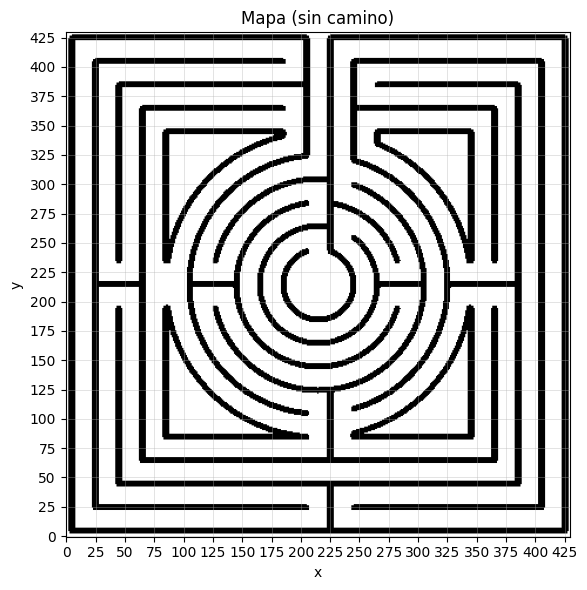

In [ ]:
IMG_PATH =  "/content/Labirinto_003.png"

grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

In [ ]:
start = (210, 10)
goal = (225, 225)

path_rrt = rrt_plan(
    grid,
    start,
    goal,
    step_size=2,
    goal_sample_rate=0.08,
    max_iters=60000,
    goal_tolerance=20,
)

if path_rrt == None:
  print("ERROR. No se encontró un camino válido")
else:
  plot_and_save(grid, start, goal, path_rrt, out_path="rrt_result.png", title="RRT planning")


ERROR. No se encontró un camino válido


## **Planta de El Prado**

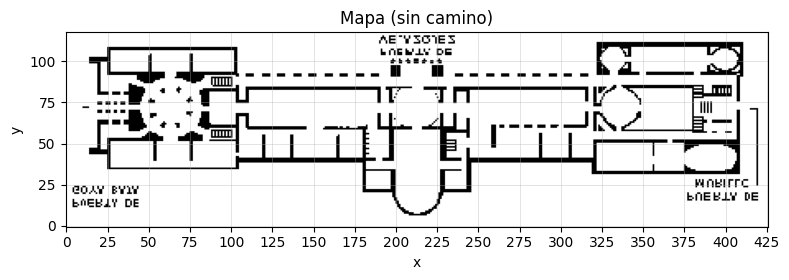

In [ ]:
IMG_PATH =  "/content/Planta_de_El_Prado.png"

grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

In [ ]:
start = (60, 70)
goal = (400, 70)

path_rrt = rrt_plan(
    grid,
    start,
    goal,
    step_size=2,
    goal_sample_rate=0.08,
    max_iters=60000,
    goal_tolerance=20,
)

if path_rrt == None:
  print("ERROR. No se encontró un camino válido")
else:
  plot_and_save(grid, start, goal, path_rrt, out_path="rrt_result.png", title="RRT planning", out_dir=".")

KeyboardInterrupt: 

## **Ejemplo Maze01-01**

In [ ]:
IMG_PATH =  "/content/Maze01-01.png"

grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

In [ ]:
# Coordenadas (x, y) en píxeles:
start = (15, 1)
goal = (150, 80)

path_rrt = rrt_plan(
    grid,
    start,
    goal,
    step_size=5,
    goal_sample_rate=0.08,
    max_iters=60000,
    goal_tolerance=20,
)


if path_rrt == None:
  print("ERROR. No se encontró un camino válido")
else:
  plot_and_save(grid, start, goal, path_rrt, out_path="rrt_result.png", title="RRT planning")


## **Mapa Nuestro Propio**

In [ ]:
IMG_PATH =  "/content/mapa_propio.png"

grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

In [ ]:
start = (25, 25)
goal = (575, 300)

path_rrt = rrt_plan(
    grid,
    start,
    goal,
    step_size=5,
    goal_sample_rate=0.08,
    max_iters=60000,
    goal_tolerance=20,
)


if path_rrt == None:
  print("ERROR. No se encontró un camino válido")
else:
  plot_and_save(grid, start, goal, path_rrt, out_path="rrt_result.png", title="RRT planning")


# **Comparación entre Algoritmos**

A continuación, comparamos los mapas creados por cada algoritmo, por ejemplo, para  ``` Maze01-01 ```.

